In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pylab
import sys
from sklearn.naive_bayes import BernoulliNB, MultinomialNB


sys.path.append("../code/")
import utils
import LR2NB_GP
%load_ext autoreload
%autoreload 2

## Loading The Dataset

In [2]:
adult_encoding = [[0, 1, 2, 3, 4],[5, 6, 7, 8, 9, 10, 11, 12, 13],[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],[46, 47, 48, 49, 50, 51, 52],[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],[68, 69, 70, 71, 72, 73],[74, 75, 76, 77, 78],[79, 80],[81, 82, 83, 84, 85],[86, 87, 88, 89, 90],[91, 92, 93, 94, 95],[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]]
X_train, y_train, X_test, y_test = utils.load_dataset("adult_income", "adult")

### Learning Logistic Regression

In [3]:
clf = LogisticRegression(solver='lbfgs', 
    verbose=True, 
    C = 0.1,
    max_iter=2000, n_jobs=6).fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    6.5s finished


In [4]:
print("LR Train Accuracy: {} \nLR Test  Accuracy: {}".format(np.average(clf.predict(X_train) == y_train), 
                                                     np.average(clf.predict(X_test) == y_test)))

LR Train Accuracy: 0.857033169533 
LR Test  Accuracy: 0.855548730549


### Learning NaCL

In [5]:
# Using Mosek Solver
W = np.hstack((clf.intercept_[:,None], clf.coef_))[0]
nacl = LR2NB_GP.LR2NB(W)
nacl.setObj(X_train, y_train)
nacl.solve(solver = 'mosek_cli', verbose=1)

Using solver 'mosek_cli'
Solving for 554 variables.
Solving took 0.128 seconds.


In [6]:
# Sanity Check to compare NaCL results with Logistic Regression
assert(1.0 == np.average( nacl.classify(X_test)  == clf.predict(X_test )))
assert(1.0 == np.average( nacl.classify(X_train) == clf.predict(X_train)))

print("NaCL Train Accuracy: {} \nNaCL Test  Accuracy: {}".format(np.average(nacl.classify(X_train) == y_train), 
                                                     np.average(nacl.classify(X_test) == y_test)))

NaCL Train Accuracy: 0.857033169533 
NaCL Test  Accuracy: 0.855548730549


Now Let us compare accuracy with a directly trained Naive Bayes model. As we see the accuracy is lower.

In [7]:
NB = BernoulliNB().fit(X_train, y_train)
print("NB Train Accuracy: {} \nNB Test  Accuracy: {}".format(np.average(NB.predict(X_train) == y_train), 
                                                     np.average(NB.predict(X_test) == y_test)))

NB Train Accuracy: 0.805947993448 
NB Test  Accuracy: 0.806715806716


# Missing Features Experiments

In [8]:
%%time
setting = {
    "repeat": 5, # 100
    "k": [i for i in range(0, 14, 1)],
    "prob" : True,
    "function": utils.conditional_likelihood_k,
    "feature_encoding": adult_encoding,
    "verbose": False
}
data_a2 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

CPU times: user 1min 56s, sys: 40.7 s, total: 2min 37s
Wall time: 1min 33s


<module 'matplotlib.pyplot' from '/home/pasha/Desktop/ucla-lab/missing/gpkit2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

/home/pasha/Desktop/ucla-lab/missing/gpkit2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


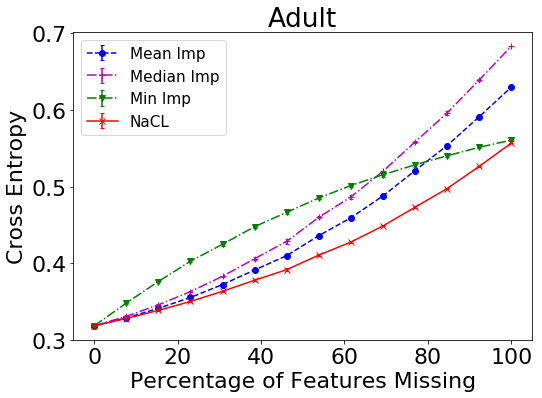

In [9]:
setting = {
    "show": ["min", "mean", "median", "ours"],
    "saveAs": "../results/demo_cross.pdf",
    "title": "Adult",
    "Ylabel": "Cross Entropy"
}
utils.plot_results_paper(data_a2, setting)

In [10]:
%%time
from sklearn.metrics import f1_score 

accuracy = lambda x,y: np.mean(x == y)
f1 = lambda x,y: f1_score(x,y.flatten(), average = "micro")

setting = {
    "repeat": 7,#100
    "k": [i for i in range(0, 14, 1)],
    "prob" : False,
    "function": f1,
    "feature_encoding": adult_encoding,
    "verbose": False
}
data_a3 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

CPU times: user 3min 30s, sys: 1min 35s, total: 5min 5s
Wall time: 2min 37s


<module 'matplotlib.pyplot' from '/home/pasha/Desktop/ucla-lab/missing/gpkit2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

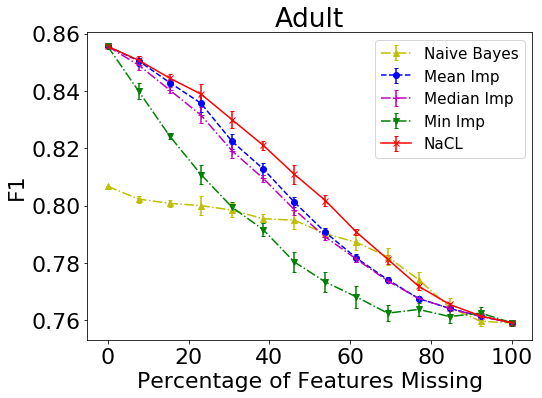

In [11]:
setting = {
    "show": ["min", "ours", "mean", "median" , "nb"],
    "saveAs": "../results/demo_accuracy.pdf",
    "title": "Adult",
    "Ylabel": "F1"
}
utils.plot_results_paper(data_a3, setting)